This notebook was ceated by Nursultan Sheishekeyev, Mateusz Zbigniew Zalewski and Ferran Oliver Gerones for a special course at DTU.

# Sugarcane Leaf Disease data set 
**Dataset information** 

[Dataset](https://www.kaggle.com/datasets/nirmalsankalana/sugarcane-leaf-disease-dataset/data) from Kaggle. This is a dataset of manually collected images of sugarcane leaves. The images are classified according to five categories: Healthy, Mosaic, Redrot, Rust and Yellow disease. Therefore, the task is a multi-class classification problem. The data in a folder with 5 subfolders containgin images for each claass in each subfolder. 


Import libraries and packages

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns
import tensorflow as tf
from glob import glob
from PIL import Image
from sklearn.metrics import classification_report
from tensorflow import keras

os.environ['KMP_DUPLICATE_LIB_OK']='True' #bug fixing

Data directory and class investigation

In [2]:
data_dir="data/Sugarcane"
print(os.listdir(data_dir)) #print the different classes of sugarcane leafs in the folder

class_names=os.listdir(data_dir) #list of classes in the directory 
print(class_names) 

##show file names in of all 5 classes in the directory to see as a for loop. 

# for i in class_names: 
#     print(i)
#     print(os.listdir(data_dir+"/"+i))

['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']
['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']


In [3]:
#Save directory for all images in a list
all_images=glob(data_dir+"/*/*.*")

#Scanning the list for image types by difining the "filetype" split by "." and taking the last element of the list
all_image_types=set([i.split(".")[-1] for i in all_images])
print(all_image_types)


#Scaning the data directories for classes for unique image name without numbering
keywords = ['healthy', 'mosaic', 'redrot', 'rust', 'yellow']

for i in class_names: 
    print(i)
    files = os.listdir(data_dir+"/"+i)
    for file in files:
        # Remove numbers from the file name
        file_without_numbers = re.sub(r'\d+', '', file)
        # Check if the file name without numbers is one of the keywords
        if file_without_numbers in keywords:
            print(file)


{'jpeg'}
Healthy
Mosaic
RedRot
Rust
Yellow


All images are .jpeg files and 5 classes ['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow'] of sugercane leafs stores in 5 subfolders

## Investigation of the images of Sugarcane leafs 
Based on the work from older notebooks made in this cource

Visualisation of images

In [4]:
#number of desired images to show
num_images=3

#function to load random images from a class and add resolution information
def load_random_images(class_name, num_images):

    image_paths = glob(f"data/Sugarcane/{class_name}/*") #import images from directory 
    random_paths = random.sample(image_paths, min(num_images, len(image_paths))) # pick random pictures 
    images = [mpimg.imread(path) for path in random_paths] #generate image 
    resolutions = [Image.open(path).size for path in random_paths] #image resolution

    return images, class_name, resolutions


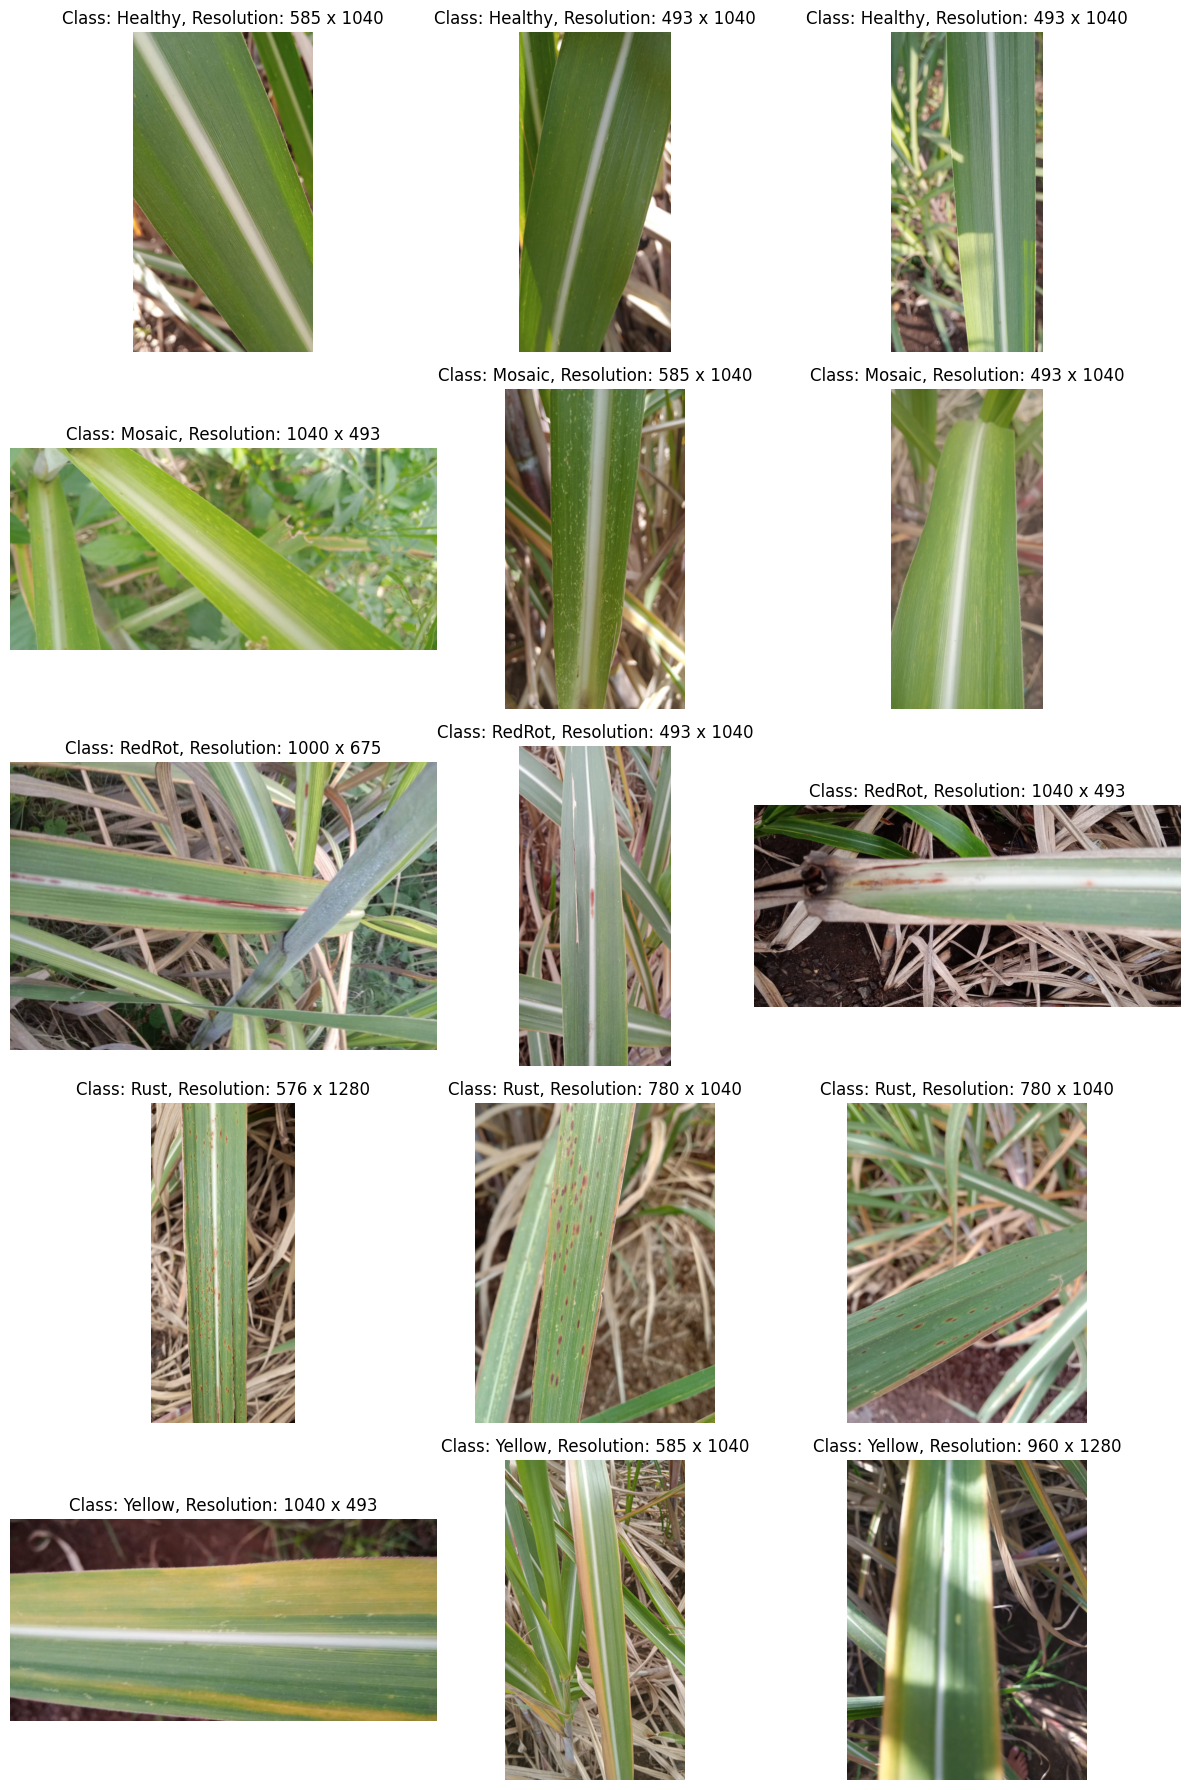

In [5]:
# Plot three random images from each class 3x5
fig, axes = plt.subplots(len(class_names), num_images, figsize=(12, 18))

for row, class_name in zip(axes, class_names): #zip function to iterate over two lists at the same time
    imgs, label, resolutions = load_random_images(class_name, num_images) #function from cell above
    for ax, img, resolution in zip(row, imgs, resolutions): #zip function to iterate over three lists at the same time to extract image, label and resolution
        ax.imshow(img)
        ax.set_title(f"Class: {label}, Resolution: {resolution[0]} x {resolution[1]}")
        ax.axis('off')
        #for each ax in subplots plot, the image, label info and resolution info

plt.tight_layout() 
plt.show()


#5*3 subplot same procedure as above but working with columns and not rows per class. 
# fig, axes = plt.subplots(num_images, len(class_names), figsize=(12, 18))

# for col, class_name in zip(axes.T, class_names):
#     imgs, label, resolutions = load_random_images(class_name, num_images)
#     for ax, img, resolution in zip(col, imgs, resolutions):
#         ax.imshow(img)
#         ax.set_title(f"Class: {label}, Resolution: {resolution[0]} x {resolution[1]}")
#         ax.axis('off')

# plt.tight_layout()
# plt.show()

From the plot of images, it shows that the resolutions of images are different, for each random image for all classes. 
For image classification preprocessing may be needed due to the high difference in resolutions. 

**Investigation of the resolution of all images**

In [6]:
# Lists to store resolutions for all images in each class
all_resolutions = []

#function to extract resolution data from images 
def load_all_images_resolution(images):
    resolutions = [] #empty list to store resolutions for each image

    for image_path in images:
        # Analyze image resolution
        resolution = Image.open(image_path).size #open image and extract resolution
        resolutions.append(resolution) #append resolution to list for each image
        all_resolutions.append(resolution) #append resolution to list for all images in all classes

    return resolutions




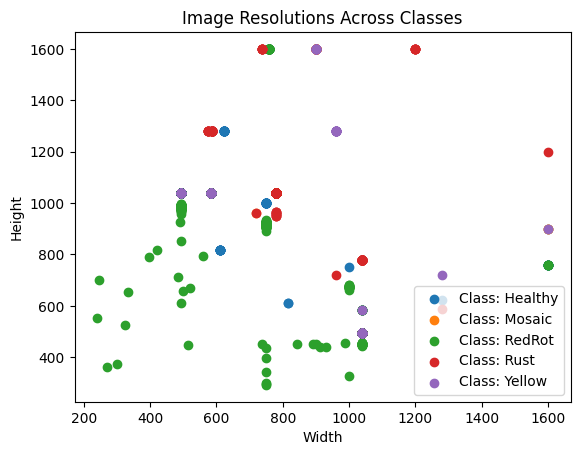

In [7]:
# Load resolutions for all images

img_array = np.array(glob("data/Sugarcane/*/*")) #create np.array of all images in all classes
resolutions_per_class = {} #empty dictionary to store resolutions per class

for class_name in class_names: #iterate over all classes
    class_images = [image for image in img_array if class_name in image] #create list of images per class
    resolutions = load_all_images_resolution(class_images) #load resolution data for each image in each class
    resolutions_per_class[class_name] = resolutions #store resolution data per class in dictionary
    # Plot scatter plot for image resolutions within each class
    resolutions_np = np.array(resolutions)
    plt.scatter(resolutions_np[:, 0], resolutions_np[:, 1], label=f"Class: {class_name}")

# Plot scatter plot for image resolutions across all classes
all_resolutions_np = np.array(all_resolutions)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Resolutions Across Classes")
plt.legend()
plt.show()

From the plot the resolutions of images have high differences in the format type. Important to standardise it for model classifier. 

**Investigation of the dimensions of the classes**

In [8]:
#function to count images in classes
def count_images_in_class(class_name): #function to count images in each class
    images = np.array(glob(f"data/Sugarcane/{class_name}/*")) #create np.array of all images in all classes
    count = len(images) #count images in each class
    return count

Total number of images: 2521
Number of images per class:
Healthy: 522
Mosaic: 462
RedRot: 518
Rust: 514
Yellow: 505


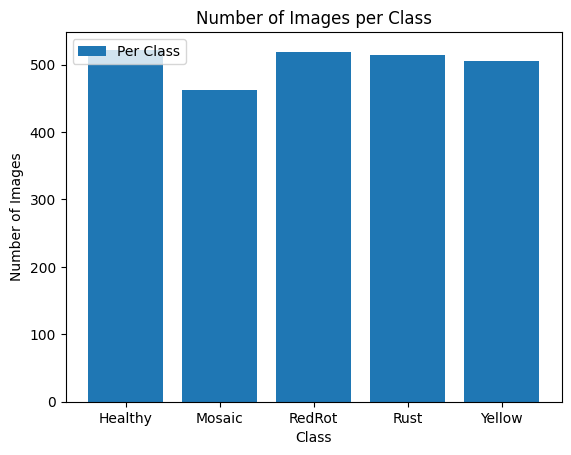

In [9]:
# Variables to store total count and count per class
total_count = 0 #initial count of images 
count_per_class = {} #empty dictionary to store count per class

# Count images for each class
for class_name in class_names: 
    count = count_images_in_class(class_name) #count images in each class
    count_per_class[class_name] = count #store count per class in dictionary
    total_count += count #add count per class to total count

# Print total count
print(f"Total number of images: {total_count}")

# Print count per class
print("Number of images per class:")
for class_name, count in count_per_class.items():
    print(f"{class_name}: {count}")

# Create a bar chart to visualize the count of different classes
fig, ax = plt.subplots()
ax.bar(count_per_class.keys(), count_per_class.values(), label='Per Class')
#ax.bar('Total', total_count, color='orange', label='Total')
ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Class')
ax.legend()
plt.show()

The results shows the classes are not balance. However since all classes are +-500, and the differences in class sizes quite small. We continue. 

## Model building 

https://www.geeksforgeeks.org/visualizing-representations-of-outputs-activations-of-each-cnn-layer/ 

https://www.kaggle.com/code/quadeer15sh/grad-cam-what-do-cnns-see 

https://keras.io/examples/vision/visualizing_what_convnets_learn/ 

https://keras.io/api/models/sequential/#sequential-class

https://www.geeksforgeeks.org/python-image-classification-using-keras/ 

https://www.tensorflow.org/tutorials/keras/overfit_and_underfit 

https://www.kaggle.com/code/uysimty/keras-cnn-dog-or-cat-classification 



In [10]:
epochs = 50 #number of epochs for training - large epoch may leed to overfitting, but keep constant for all models
image_size = (128, 128)
input_shape = (128, 128, 3) #image size and color channels
dataset_dir = "data/Sugarcane"
seed = 123 #random seed for reproducibility
batch_size = 32 #batch size for training
buffer_size = 250 #buffer size for shuffling
fine_tune_point = 125 
learning_rate = 0.001 #learning rate for optimizer



In [11]:
#using keras - divide images into training and validation sets, which also includes preprocessing of the images.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    labels="inferred", 
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="training"
) 

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    labels="inferred",
    batch_size=batch_size,
    image_size=image_size,
    seed=seed,
    validation_split=0.2,
    subset="validation"
)

Found 2521 files belonging to 5 classes.
Using 2017 files for training.
Found 2521 files belonging to 5 classes.
Using 504 files for validation.


In [12]:
#check the images shapes after preprocessing

class_names = train_ds.class_names #extract class names from training set
for example_image, example_label in train_ds.take(1): #take one image and label from training set
  break

print(f"Image Shape: {example_image.shape}")



Image Shape: (32, 128, 128, 3)


In [13]:
validation_ds = validation_ds.shard(num_shards=2, index=0) #split validation set into two shards for faster processing
test_ds = validation_ds.shard(num_shards=2, index=1) #split test set into two shards  for faster processing


In [14]:
train_ds = train_ds.cache().shuffle(buffer_size).prefetch(buffer_size=tf.data.AUTOTUNE) #cache and shuffle training set
validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE) #cache validation set
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE) #cache test set

**Simple Model**

In [15]:
#bulding a simple model with keras

simple_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(128, 128, 3)), #flatten the input shape
    tf.keras.layers.Dense(8, activation='relu'), #dense layer with 8 neurons and relu activation function
    tf.keras.layers.Dense(len(class_names)) #dense layer with number of neurons equal 5 classes
])
#dummy input for model summary 
dummy_input = tf.random.normal(shape=(1, 128, 128, 3)) #create dummy input for model

simple_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
) #compile model with optimizer, loss function and metrics

# Call the model with a dummy input to trigger the build process
simple_model(dummy_input) 

# Now you can print the summary
simple_model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 8)                 393224    
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
Total params: 393269 (1.50 MB)
Trainable params: 393269 (1.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
from tensorflow.keras.callbacks import EarlyStopping

#Define early stopping - not relevant when epochs are set to 50 for all models. But can be used in order to stop training when validation loss does not improve anymore. 
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value
)


simple_modelhistory = simple_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    #callbacks=[early_stopping]
) #fit model to training data and validate on validation data

#save the model
simple_model.save('simple_model.h5')

Epoch 1/50


64/64 [==============================] - 10s 38ms/step - loss: 8.5304 - accuracy: 0.2033 - val_loss: 1.6097 - val_accuracy: 0.1562
Epoch 2/50
64/64 [==============================] - 0s 7ms/step - loss: 1.6092 - accuracy: 0.2033 - val_loss: 1.6096 - val_accuracy: 0.1562
Epoch 3/50
64/64 [==============================] - 0s 7ms/step - loss: 1.6091 - accuracy: 0.2087 - val_loss: 1.6095 - val_accuracy: 0.2266
Epoch 4/50
64/64 [==============================] - 0s 7ms/step - loss: 1.6089 - accuracy: 0.2048 - val_loss: 1.6094 - val_accuracy: 0.2266
Epoch 5/50
64/64 [==============================] - 0s 7ms/step - loss: 1.6088 - accuracy: 0.2048 - val_loss: 1.6094 - val_accuracy: 0.2266
Epoch 6/50
64/64 [==============================] - 0s 7ms/step - loss: 1.6088 - accuracy: 0.2048 - val_loss: 1.6094 - val_accuracy: 0.2266
Epoch 7/50
64/64 [==============================] - 0s 8ms/step - loss: 1.6087 - accuracy: 0.2048 - val_loss: 1.6094 - val_accuracy: 0.2266
Epoch 8/50
64/64

c:\Users\nshei\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Text(0.5, 0, 'Epoch')

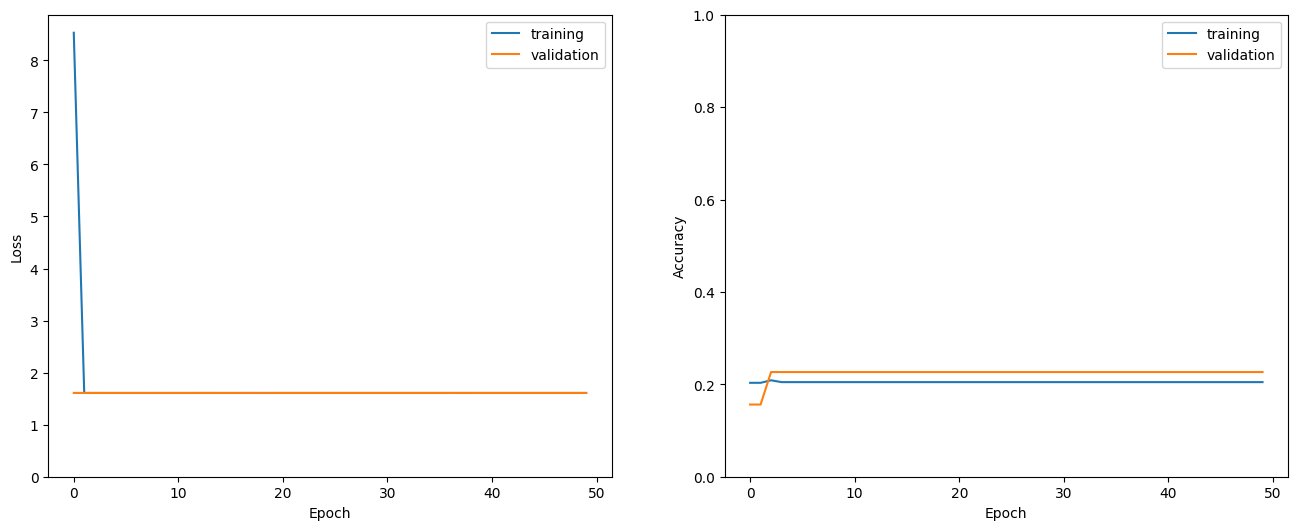

In [17]:
#accuary and loss plot
simple_model_metrics = simple_modelhistory.history #extract metrics from history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(simple_modelhistory.epoch, simple_model_metrics['loss'], simple_model_metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(simple_modelhistory.epoch, simple_model_metrics['accuracy'], simple_model_metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

4/4 [==============================] - 0s 5ms/step


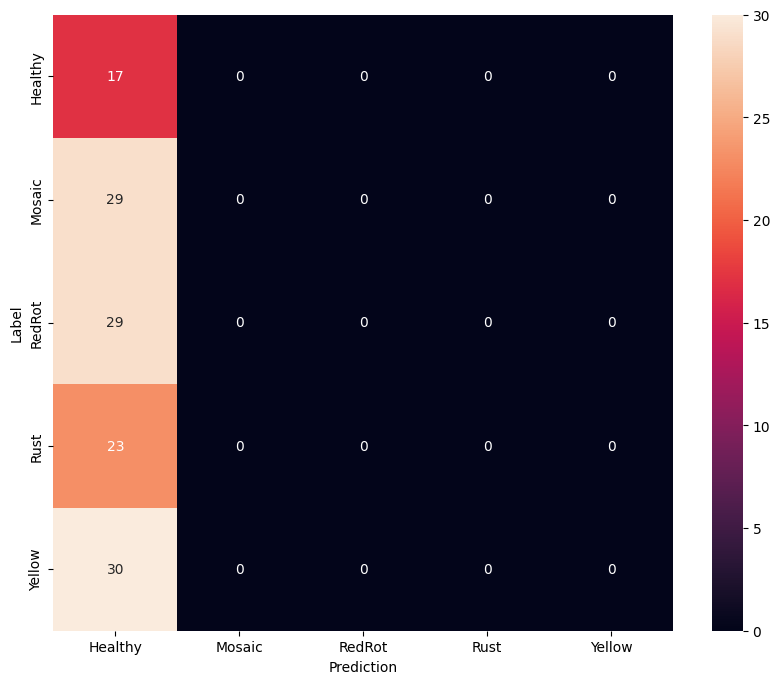

              precision    recall  f1-score   support

     Healthy       0.13      1.00      0.23        17
      Mosaic       0.00      0.00      0.00        29
      RedRot       0.00      0.00      0.00        29
        Rust       0.00      0.00      0.00        23
      Yellow       0.00      0.00      0.00        30

    accuracy                           0.13       128
   macro avg       0.03      0.20      0.05       128
weighted avg       0.02      0.13      0.03       128



c:\Users\nshei\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nshei\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nshei\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
simple_model.evaluate(test_ds, return_dict=True) #evaluate model on test data

y_pred_simple = simple_model.predict(test_ds) #predict labels for test data
y_pred_simple = np.argmax(y_pred_simple, axis=1) #extract predicted labels from test data
y_true_simple = np.concatenate([y for x, y in test_ds], axis=0) #extract true labels from test data

confusion_mtx = tf.math.confusion_matrix(y_true_simple, y_pred_simple) #create confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()



print(classification_report(y_true_simple, y_pred_simple, target_names=class_names))

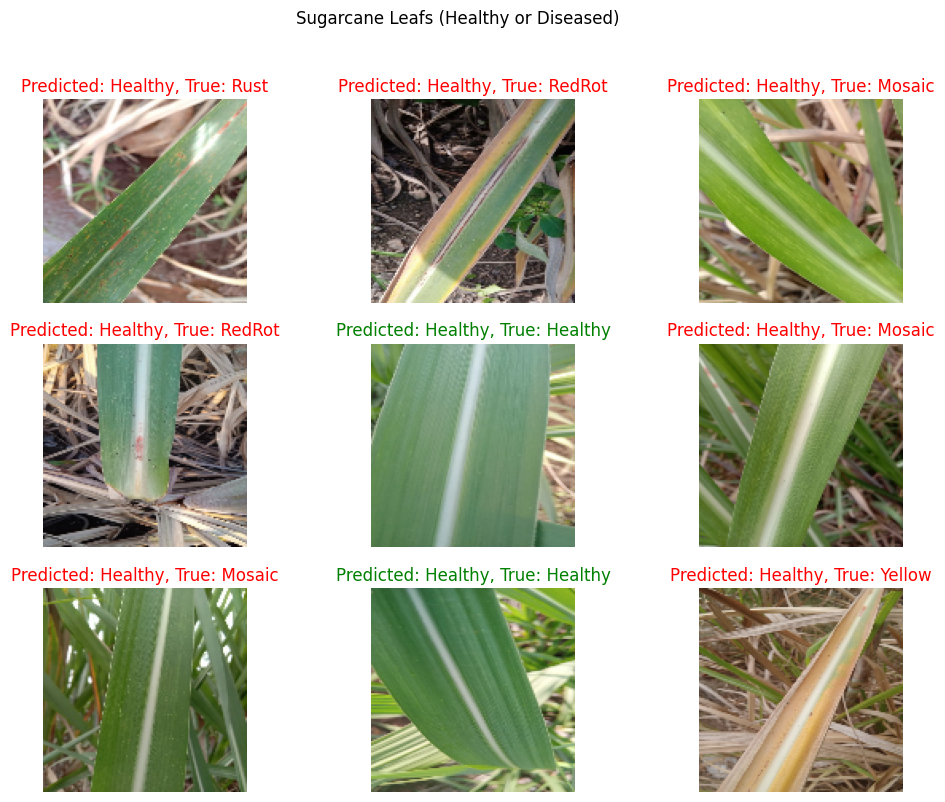

In [19]:
#plot of 9 random images from test set with predicted and true label
plt.figure(figsize=(12, 9))
for images, labels in test_ds.take(1): #take one image and label from test set
    for i in range(9): #iterate over 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8")) #plot image
        color = 'green' if y_pred_simple[i] == labels[i] else 'red' #if predicted label is the same as true label, color is green, else red
        plt.title(f"Predicted: {class_names[y_pred_simple[i]]}, True: {class_names[labels[i]]}", color=color) #add predicted and true label to title
        plt.suptitle("Sugarcane Leafs (Healthy or Diseased)")
        plt.axis("off")

plt.show()

1/1 [==============================] - 0s 112ms/step


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 1:
Predicted class: 0
True class: 4
Image 2:
Predicted class: 0
True class: 4


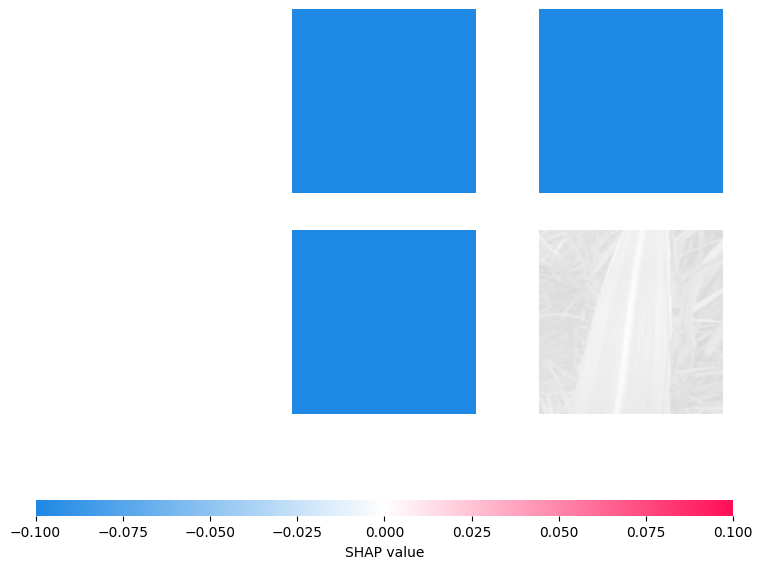

In [20]:
import shap
import numpy as np

#Convert the TensorFlow dataset to numpy array
test_ds_numpy = np.concatenate([x for x, _ in test_ds], axis=0)
test_labels = np.concatenate([y for _, y in test_ds], axis=0)  # Get the true labels

#Select two images from the test set - just some random from the test set. 
selected_images = test_ds_numpy[8:10]
selected_labels = test_labels[8:10]  # Select the true labels for the selected images

#predictions for the selected images
predictions = simple_model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)  # Get the predicted classes

#shap explainer for the model predictions for selected_images
explainer = shap.GradientExplainer(simple_model, selected_images)

#shap values from explainer
shap_values, indexes = explainer.shap_values(selected_images, ranked_outputs=2)

#Plot shap values
shap.image_plot(shap_values, selected_images,show=False)


#Print the predicted and true classes
for i in range(len(selected_images)):
    print(f"Image {i+1}:")
    print(f"Predicted class: {predicted_classes[i]}")
    print(f"True class: {selected_labels[i]}")

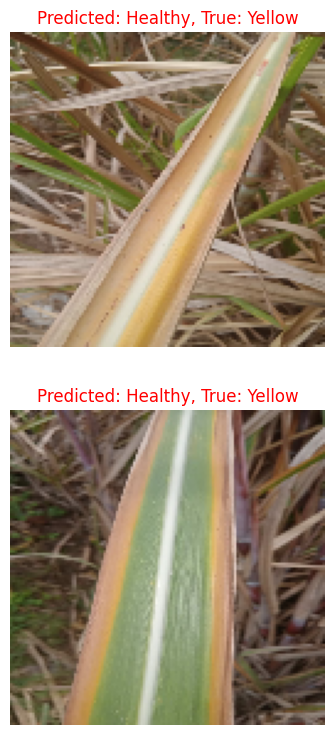

In [21]:
# Plot the predicted and true classes from tensorflow dataset for the two random picked images from the test set. 
plt.figure(figsize=(12, 9))

for i in range(len(selected_images)):
    ax = plt.subplot(len(selected_images), 1, i + 1)   #Create a subplot for each image
    plt.imshow(selected_images[i].astype("uint8")) #plot image
    color = 'green' if predicted_classes[i] == selected_labels[i] else 'red' #add color to true or false prediction
    plt.title(f"Predicted: {class_names[predicted_classes[i]]}, True: {class_names[selected_labels[i]]}", color=color)
    plt.axis("off")

**Adding more layers and modifications to the simple model** **Medium model**

In [22]:
#medium model
medium_model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),#rescale image to [0,1] range
    tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'), #randomly flip images horizontally and vertically
    tf.keras.layers.Conv2D(32, 3, activation='relu'), #convolutional layer with 32 filters, kernel size 3 and relu activation function
    tf.keras.layers.Flatten(), #flatten the input shape
    tf.keras.layers.Dense(32, activation='relu'), #dense layer with 32 neurons and relu activation function
    tf.keras.layers.Dropout(0.20), #dropout layer with 20% dropout rate
    tf.keras.layers.Dense(8, activation='relu'), #dense layer with 64 neurons and relu activation function
    tf.keras.layers.Dense(len(class_names)),#dense layer with number of neurons equal 5 classes
    
])
# dummy input to create model summary
dummy_input = tf.random.normal(shape=(1, 128, 128, 3)) #create dummy input for model

medium_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
) #compile model with optimizer, loss function and metrics

# Call the model with a dummy input to trigger the build process
medium_model(dummy_input) 

# Now you can print the summary
medium_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (1, 128, 128, 3)          0         
                                                                 
 random_flip (RandomFlip)    (1, 128, 128, 3)          0         
                                                                 
 conv2d (Conv2D)             (1, 126, 126, 32)         896       
                                                                 
 flatten_1 (Flatten)         (1, 508032)               0         
                                                                 
 dense_2 (Dense)             (1, 32)                   16257056  
                                                                 
 dropout (Dropout)           (1, 32)                   0         
                                                                 
 dense_3 (Dense)             (1, 8)                   

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping but not relevant when epochs are set to 50 for all models. But can be used in order to stop training when validation loss does not improve anymore.
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value
)

#fit model to training data and validate on validation data
medium_modelhistory = medium_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    #callbacks=[early_stopping]
) #fit model to training data and validate on validation data

#save the model
medium_model.save('medium_model.h5')

Epoch 1/50
64/64 [==============================] - 17s 236ms/step - loss: 3.4413 - accuracy: 0.2127 - val_loss: 1.5739 - val_accuracy: 0.2148
Epoch 2/50
64/64 [==============================] - 17s 272ms/step - loss: 1.5502 - accuracy: 0.2811 - val_loss: 1.4822 - val_accuracy: 0.3359
Epoch 3/50
64/64 [==============================] - 17s 270ms/step - loss: 1.5074 - accuracy: 0.3193 - val_loss: 1.4592 - val_accuracy: 0.3086
Epoch 4/50
64/64 [==============================] - 16s 243ms/step - loss: 1.4461 - accuracy: 0.3540 - val_loss: 1.3976 - val_accuracy: 0.3555
Epoch 5/50
64/64 [==============================] - 15s 237ms/step - loss: 1.3702 - accuracy: 0.4075 - val_loss: 1.3681 - val_accuracy: 0.4297
Epoch 6/50
64/64 [==============================] - 15s 237ms/step - loss: 1.2703 - accuracy: 0.4556 - val_loss: 1.2452 - val_accuracy: 0.5039
Epoch 7/50
64/64 [==============================] - 15s 234ms/step - loss: 1.2340 - accuracy: 0.5052 - val_loss: 1.1516 - val_accuracy: 0.6016

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


Text(0.5, 0, 'Epoch')

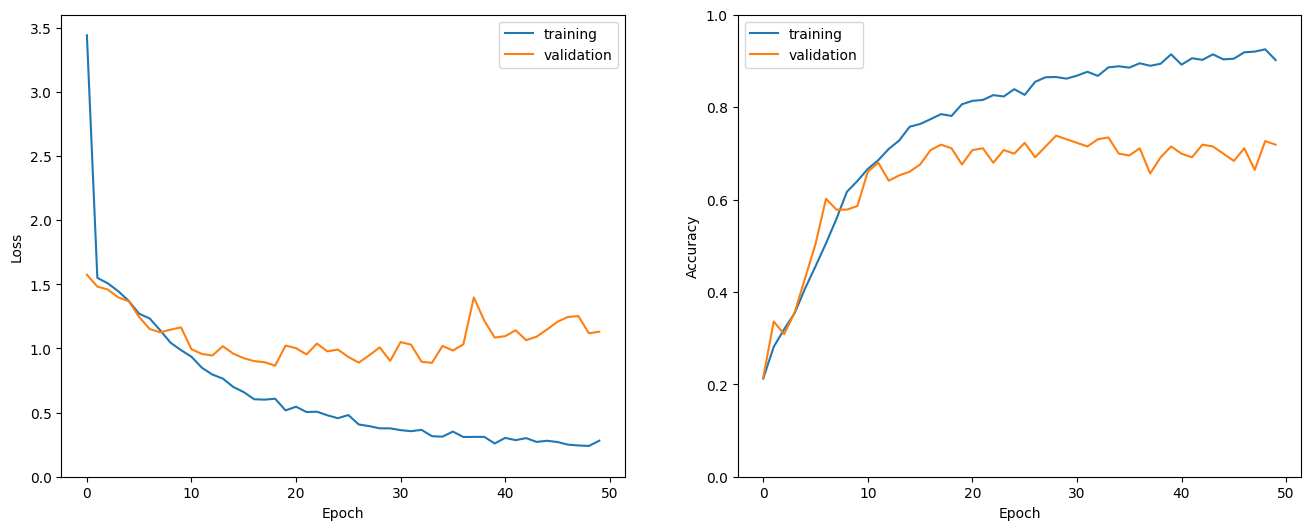

In [24]:
#accuary and loss plot
medium_model_metrics = medium_modelhistory.history #extract metrics from history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(medium_modelhistory.epoch, medium_model_metrics['loss'], medium_model_metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(medium_modelhistory.epoch, medium_model_metrics['accuracy'], medium_model_metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

4/4 [==============================] - 0s 33ms/step


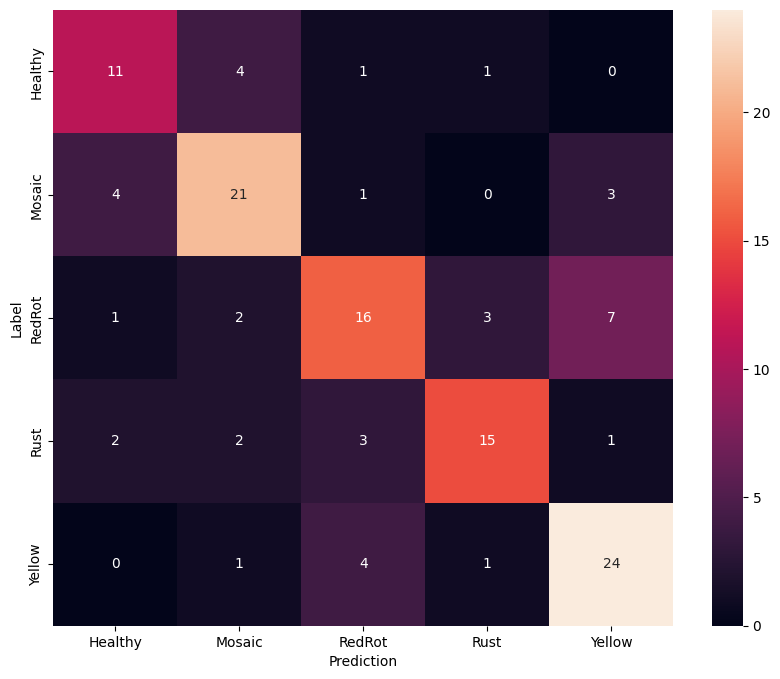

              precision    recall  f1-score   support

     Healthy       0.61      0.65      0.63        17
      Mosaic       0.70      0.72      0.71        29
      RedRot       0.64      0.55      0.59        29
        Rust       0.75      0.65      0.70        23
      Yellow       0.69      0.80      0.74        30

    accuracy                           0.68       128
   macro avg       0.68      0.68      0.67       128
weighted avg       0.68      0.68      0.68       128



In [25]:
#evaluate model on test data and print confusion matrix
medium_model.evaluate(test_ds, return_dict=True) #evaluate model on test data

y_pred_medium = medium_model.predict(test_ds) #predict labels for test data
y_pred_medium = np.argmax(y_pred_medium, axis=1) #extract predicted labels from test data
y_true_medium = np.concatenate([y for x, y in test_ds], axis=0) #extract true labels from test data

confusion_mtx = tf.math.confusion_matrix(y_true_medium, y_pred_medium) #create confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()



print(classification_report(y_true_medium, y_pred_medium, target_names=class_names))

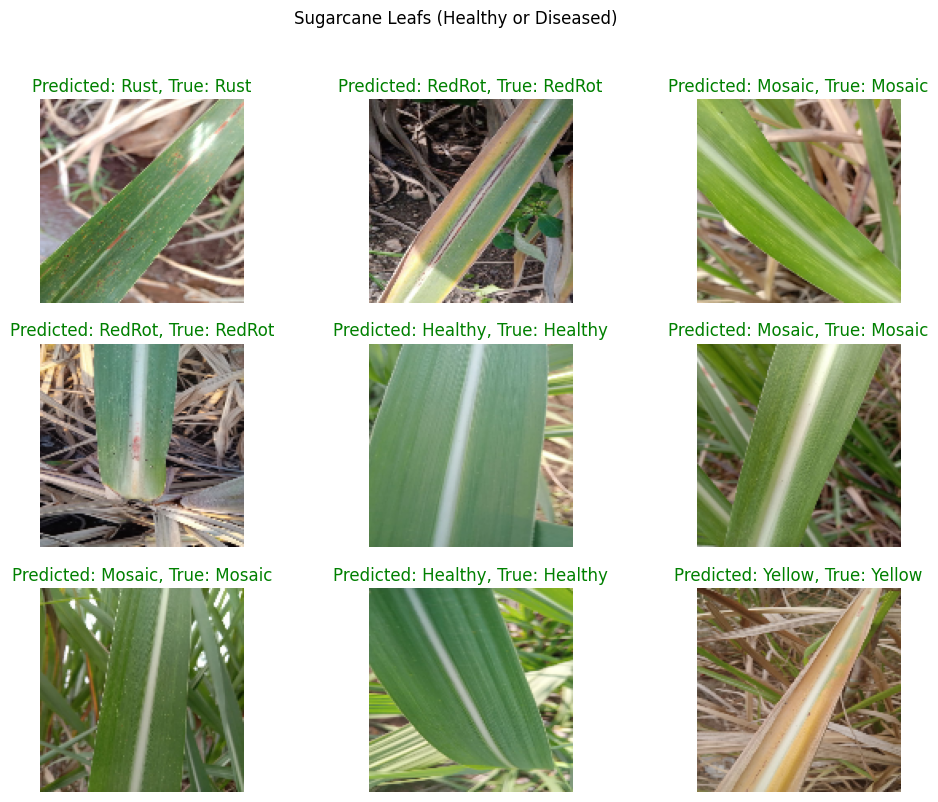

In [26]:
#plot of 9 random images from test set with predicted and true label
plt.figure(figsize=(12, 9))
for images, labels in test_ds.take(1): #take one image and label from test set
    for i in range(9): #iterate over 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8")) #plot image
        color = 'green' if y_pred_medium[i] == labels[i] else 'red' #if predicted label is the same as true label, color is green, else red
        plt.title(f"Predicted: {class_names[y_pred_medium[i]]}, True: {class_names[labels[i]]}", color=color) #add predicted and true label to title
        plt.suptitle("Sugarcane Leafs (Healthy or Diseased)")
        plt.axis("off")

plt.show()

1/1 [==============================] - 0s 143ms/step


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 1:
Predicted class: 4
True class: 4
Image 2:
Predicted class: 4
True class: 4


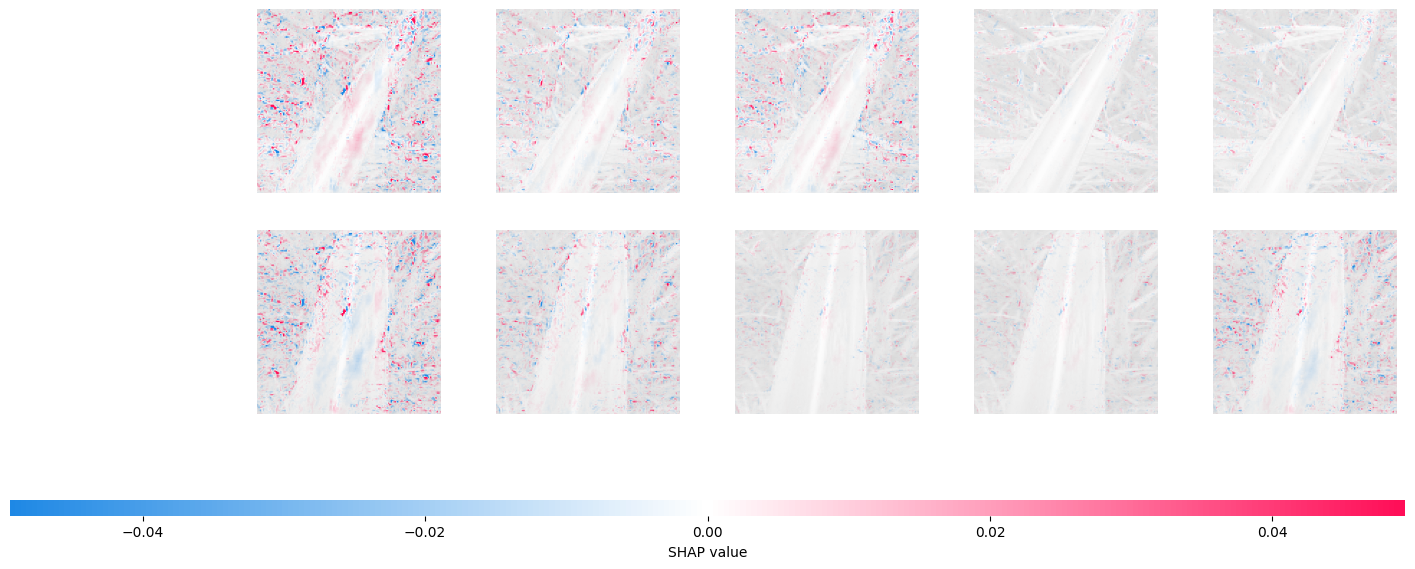

In [27]:
import shap
import numpy as np

#TensorFlow dataset to numpy array
test_ds_numpy = np.concatenate([x for x, _ in test_ds], axis=0)
test_labels = np.concatenate([y for _, y in test_ds], axis=0)  # Get the true labels

#two images from the test set
selected_images = test_ds_numpy[8:10]
selected_labels = test_labels[8:10]  # Select the true labels for the selected images

#predictions for the selected images
predictions = medium_model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)  # Get the predicted classes

#shap explainer for the model predictions for selected_images
explainer = shap.GradientExplainer(medium_model, selected_images)

#shap values from explainer
shap_values, indexes = explainer.shap_values(selected_images, ranked_outputs=8)

#Plot shap values
shap.image_plot(shap_values, selected_images,show=False)


#Print the predicted and true classes
for i in range(len(selected_images)):
    print(f"Image {i+1}:")
    print(f"Predicted class: {predicted_classes[i]}")
    print(f"True class: {selected_labels[i]}")

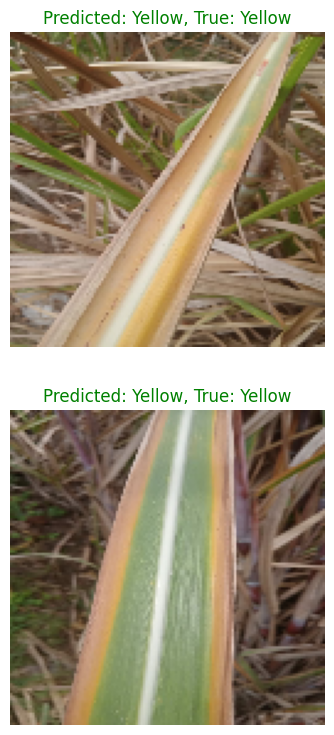

In [28]:
# Plot the predicted and true classes from tensorflow dataset for test set for the two images 
plt.figure(figsize=(12, 9))

for i in range(len(selected_images)):
    ax = plt.subplot(len(selected_images), 1, i + 1)
    plt.imshow(selected_images[i].astype("uint8"))
    color = 'green' if predicted_classes[i] == selected_labels[i] else 'red'
    plt.title(f"Predicted: {class_names[predicted_classes[i]]}, True: {class_names[selected_labels[i]]}", color=color)
    plt.axis("off")

**Large model including pretrained model MobileNetV2**

In [29]:
#large model

mobile_model = tf.keras.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
) #import pretrained model
mobile_model.trainable = True #set model to trainable

print(len(mobile_model.layers)) #print number of layers in model
for layer in mobile_model.layers[:fine_tune_point]: #freeze layers up to fine tune point
 layer.trainable = False  #set layers to not trainable


#dummy data to print summary
dummy_input = tf.random.normal(shape=(1, 128, 128, 3)) #create dummy input for model


large_model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255), #rescale image values to 0-1
    #tf.keras.layers.RandomContrast(factor=0.1),
    tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'), #randomly flip images horizontally and vertically
    mobile_model, #import mobilenetv2 model
    tf.keras.layers.GlobalAveragePooling2D(), #pooling layer to reduce dimensionality
    tf.keras.layers.Flatten(), #flatten layer to convert 2D to 1D array
    tf.keras.layers.Dense(64, activation='relu'), #dense layer with 64 neurons and relu activation function
    tf.keras.layers.Dropout(0.50), #dropout layer to prevent overfitting
    tf.keras.layers.Dense(len(class_names)) #dense layer with number of neurons equal to number of classes
]) #create model with sequential layers
# model.build(input_shape=(1, 128, 128, 3)) #build model with input shape


large_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
) #compile model with optimizer, loss function and metrics

#call the model for model summary
large_model(dummy_input) 

#print the summary
large_model.summary()


154
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (1, 128, 128, 3)          0         
                                                                 
 random_flip_1 (RandomFlip)  (1, 128, 128, 3)          0         
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (1, 1280)                 0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten_2 (Flatten)         (1, 1280)                 0         
                                                                 
 dense_5 (Dense)             (1, 64)             

In [30]:
from tensorflow.keras.callbacks import EarlyStopping


# Define early stopping but not relevant when epochs are set to 50 for all models. But can be used in order to stop training when validation loss does not improve anymore.
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value
)

large_modelhistory = large_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=50,
    #callbacks=[early_stopping]
) #fit model to training data and validate on validation data

#save the model
large_model.save('large_model.h5')

Epoch 1/50
64/64 [==============================] - 28s 266ms/step - loss: 1.0061 - accuracy: 0.6475 - val_loss: 5.3784 - val_accuracy: 0.4219
Epoch 2/50
64/64 [==============================] - 15s 228ms/step - loss: 0.5766 - accuracy: 0.8027 - val_loss: 4.9527 - val_accuracy: 0.5039
Epoch 3/50
64/64 [==============================] - 15s 226ms/step - loss: 0.4187 - accuracy: 0.8642 - val_loss: 9.2840 - val_accuracy: 0.4258
Epoch 4/50
64/64 [==============================] - 14s 224ms/step - loss: 0.3739 - accuracy: 0.8919 - val_loss: 4.8246 - val_accuracy: 0.5312
Epoch 5/50
64/64 [==============================] - 14s 222ms/step - loss: 0.3250 - accuracy: 0.9088 - val_loss: 2.6960 - val_accuracy: 0.6758
Epoch 6/50
64/64 [==============================] - 14s 222ms/step - loss: 0.2959 - accuracy: 0.9058 - val_loss: 2.9338 - val_accuracy: 0.6914
Epoch 7/50
64/64 [==============================] - 14s 225ms/step - loss: 0.1870 - accuracy: 0.9450 - val_loss: 5.7175 - val_accuracy: 0.5820

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


Text(0.5, 0, 'Epoch')

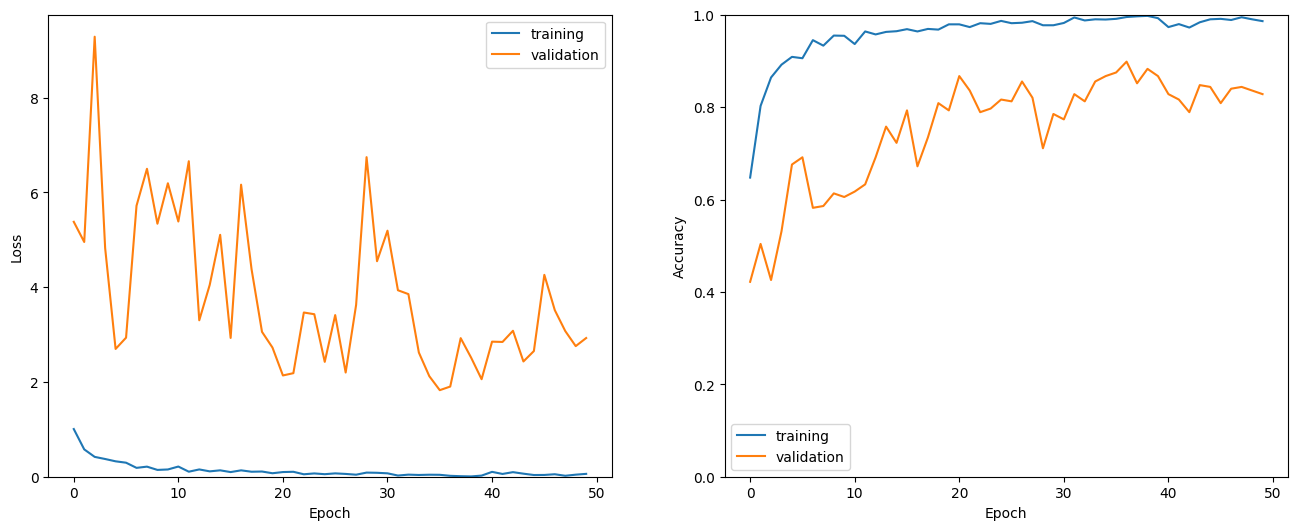

In [31]:
#export the metrics from the history of large model
large_modelmetrics = large_modelhistory.history #extract metrics from history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(large_modelhistory.epoch, large_modelmetrics['loss'], large_modelmetrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(large_modelhistory.epoch, large_modelmetrics['accuracy'], large_modelmetrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

4/4 [==============================] - 3s 162ms/step


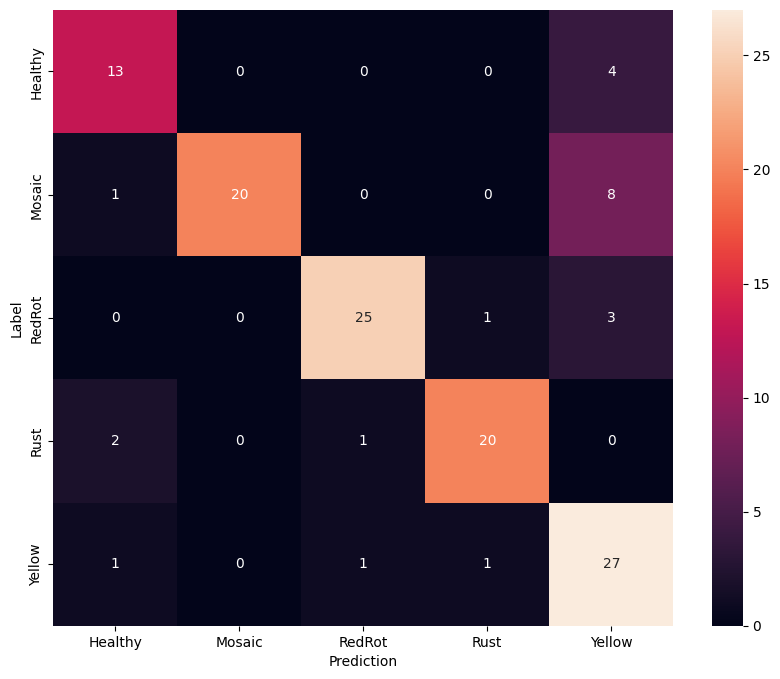

              precision    recall  f1-score   support

     Healthy       0.76      0.76      0.76        17
      Mosaic       1.00      0.69      0.82        29
      RedRot       0.93      0.86      0.89        29
        Rust       0.91      0.87      0.89        23
      Yellow       0.64      0.90      0.75        30

    accuracy                           0.82       128
   macro avg       0.85      0.82      0.82       128
weighted avg       0.85      0.82      0.82       128



In [32]:
 
large_model.evaluate(test_ds, return_dict=True) #evaluate model on test data

y_pred_large = large_model.predict(test_ds) #predict labels for test data
y_pred_large = np.argmax(y_pred_large, axis=1) #extract predicted labels from test data
y_true_large = np.concatenate([y for x, y in test_ds], axis=0) #extract true labels from test data

confusion_mtx = tf.math.confusion_matrix(y_true_large, y_pred_large) #create confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()



print(classification_report(y_true_large, y_pred_large, target_names=class_names))

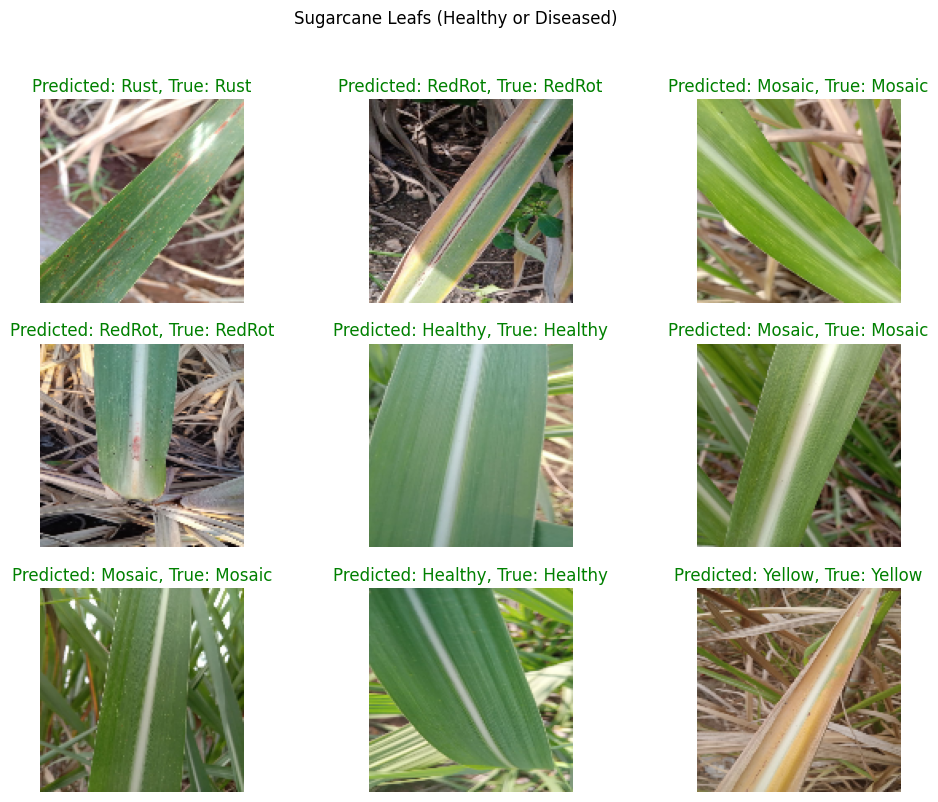

In [33]:
#image visualisaiton of the model predictions. And the true labels of the images and add the true labels to the plot title

# plt.figure(figsize=(12, 9))
# for images, labels in test_ds.take(1): #take one image and label from test set
#     for i in range(9): #iterate over 9 images
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8")) #plot image
#         plt.title(f"Predicted: {class_names[y_pred[i]]}, True: {class_names[labels[i]]}")
#         plt.suptitle("Sugarcane Leafs (Healthy or Diseased)")
#         plt.axis("off")

# plt.show()

plt.figure(figsize=(12, 9))
for images, labels in test_ds.take(1): #take one image and label from test set
    for i in range(9): #iterate over 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8")) #plot image
        color = 'green' if y_pred_large[i] == labels[i] else 'red' #if predicted label is the same as true label, color is green, else red
        plt.title(f"Predicted: {class_names[y_pred_large[i]]}, True: {class_names[labels[i]]}", color=color) #add predicted and true label to title
        plt.suptitle("Sugarcane Leafs (Healthy or Diseased)")
        plt.axis("off")

plt.show()

1/1 [==============================] - 2s 2s/step


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 1:
Predicted class: 4
True class: 4
Image 2:
Predicted class: 4
True class: 4


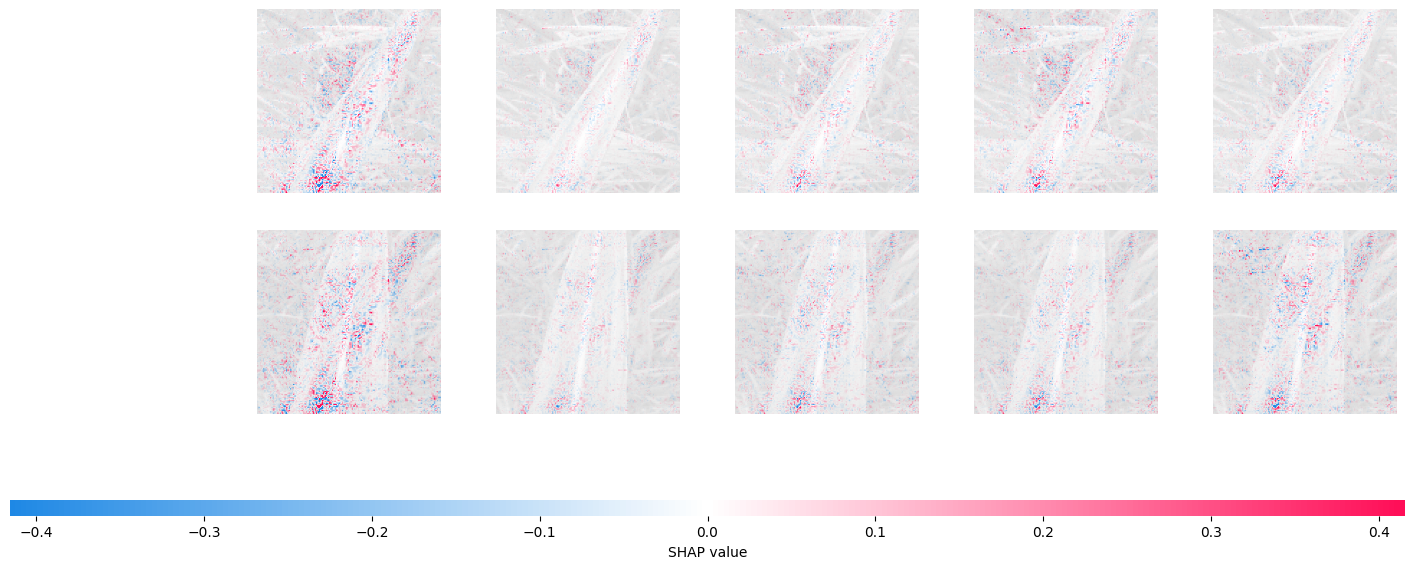

In [34]:
import shap
import numpy as np

#TensorFlow dataset to numpy array
test_ds_numpy = np.concatenate([x for x, _ in test_ds], axis=0)
test_labels = np.concatenate([y for _, y in test_ds], axis=0)  # Get the true labels

#two images from the test set
selected_images = test_ds_numpy[8:10]
selected_labels = test_labels[8:10]  # Select the true labels for the selected images

#predictions for the selected images
predictions = large_model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)  # Get the predicted classes

#shap explainer for the model predictions for selected_images
explainer = shap.GradientExplainer(large_model, selected_images)

#shap values from explainer
shap_values, indexes = explainer.shap_values(selected_images, ranked_outputs=5)

#Plot shap values
shap.image_plot(shap_values, selected_images,show=False)


#Print the predicted and true classes
for i in range(len(selected_images)):
    print(f"Image {i+1}:")
    print(f"Predicted class: {predicted_classes[i]}")
    print(f"True class: {selected_labels[i]}")

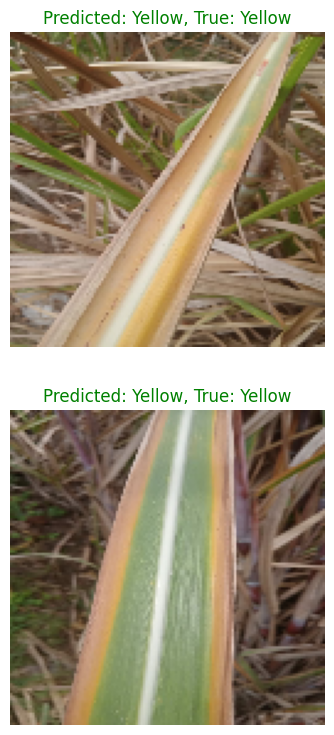

In [35]:
# Plot the predicted and true classes from tensorflow dataset for the two images
plt.figure(figsize=(12, 9))

for i in range(len(selected_images)):
    ax = plt.subplot(len(selected_images), 1, i + 1)
    plt.imshow(selected_images[i].astype("uint8"))
    color = 'green' if predicted_classes[i] == selected_labels[i] else 'red'
    plt.title(f"Predicted: {class_names[predicted_classes[i]]}, True: {class_names[selected_labels[i]]}", color=color)
    plt.axis("off")